In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imghdr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=45,     #Random rotation between 0 and 45
        width_shift_range=0.2,   #% shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')    #Also try nearest, constant, reflect, wrap

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
SIZE = 150
###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)

Found 1293 files belonging to 5 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
image_directory = '/content/drive/MyDrive/daniel/others/'
SIZE = 150
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        dataset.append(np.array(image))

x = np.array(dataset)

In [ ]:
from PIL import Image
def read_and_save_images(folder_path, folder_path1):
   """Reads images in a folder, saves them with sequential filenames, and optionally
      converts them to a specified format.

   Args:
       folder_path (str): Path to the folder containing the images.
       target_format (str, optional): Desired image format (e.g., "JPEG", "PNG").
           Defaults to None, preserving the original format.
   """

   index = 0
   for filename in os.listdir(folder_path):
       if filename.endswith((".jpg", ".jpeg", ".png", ".JPG")):  # Check for common image extensions
           filepath = os.path.join(folder_path, filename)
           try:
               with Image.open(filepath) as image:
                   new_filename = f"{index}.jpg"  # Change to desired format if needed
                   new_filepath = os.path.join(folder_path1, new_filename)
                   image.save(new_filepath)
                   index += 1
           except Exception as e:
               print(f"Error processing {filename}: {e}")

# Example usage:
folder_path = "/content/drive/MyDrive/daniel/others"  # Replace with your actual folder path
folder_path1 = "/content/drive/MyDrive/daniel/others1"
read_and_save_images(folder_path,folder_path1)

In [ ]:
from skimage import io
image_directory = '/content/drive/MyDrive/daniel/others1/'
SIZE = 128
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        dataset.append(np.array(image))

x = np.array(dataset)

i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/daniel/data/Aug_others',
                          save_prefix='aug',
                          save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [ ]:
#data = tf.keras.utils.image_dataset_from_directory('/content/ImageClassification/data')
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/daniel/data',image_size=(150, 150))

Found 1629 files belonging to 6 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
from tensorflow.keras.utils import to_categorical
data = data.map(lambda x, y: (x / 255, tf.one_hot(y, depth=6)))  # Assuming 6 classes

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [ ]:
first_batch = next(iter(train))  # Get the first batch of data
images, labels = first_batch  # Separate images and labels

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile('adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 16)        0

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
35/35 [==============================] - 31s 832ms/step - loss: 1.4682 - accuracy: 0.3375 - val_loss: 1.0958 - val_accuracy: 0.4625
Epoch 2/30
35/35 [==============================] - 33s 930ms/step - loss: 0.8486 - accuracy: 0.6759 - val_loss: 0.8285 - val_accuracy: 0.6844
Epoch 3/30
35/35 [==============================] - 34s 955ms/step - loss: 0.6047 - accuracy: 0.7982 - val_loss: 0.5350 - val_accuracy: 0.8062
Epoch 4/30
35/35 [==============================] - 27s 752ms/step - loss: 0.5285 - accuracy: 0.7902 - val_loss: 0.5934 - val_accuracy: 0.7625
Epoch 5/30
35/35 [==============================] - 28s 757ms/step - loss: 0.4502 - accuracy: 0.8375 - val_loss: 0.4012 - val_accuracy: 0.8438
Epoch 6/30
35/35 [==============================] - 29s 810ms/step - loss: 0.3663 - accuracy: 0.8598 - val_loss: 0.5737 - val_accuracy: 0.7937
Epoch 7/30
35/35 [==============================] - 29s 823ms/step - loss: 0.3075 - accuracy: 0.8884 - val_loss: 0.4517 - val_accuracy: 0.8375

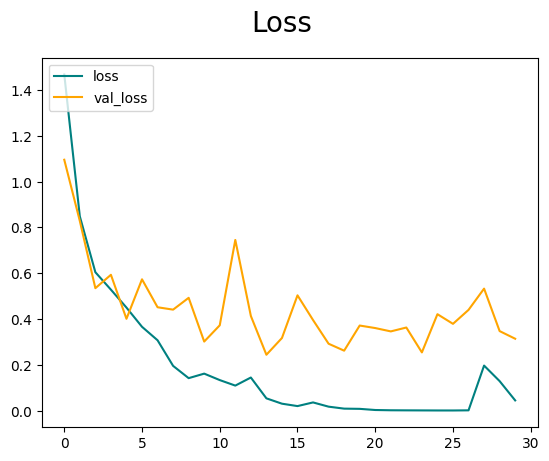

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

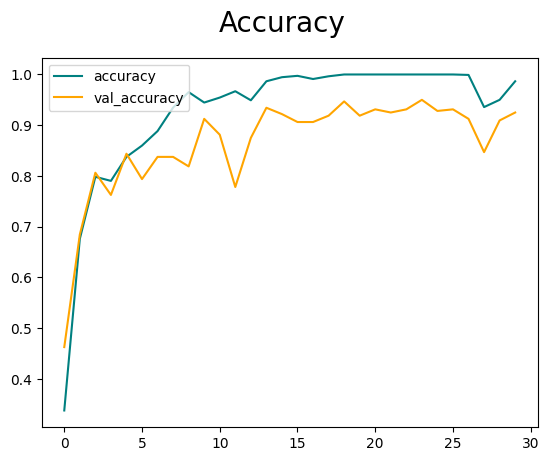

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 266ms/step
tf.Tensor(0.9125, shape=(), dtype=float32) tf.Tensor(0.9125, shape=(), dtype=float32) tf.Tensor(0.97083336, shape=(), dtype=float32)
